In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = l1_regularizer,
    mask = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.8333333333333334, Loss: 0.672111087375217
Checkpoint 200, Accuracy: 0.8333333333333334, Loss: 0.6747787616871022
Checkpoint 300, Accuracy: 0.8333333333333334, Loss: 0.669981426662869
Checkpoint 400, Accuracy: 0.8333333333333334, Loss: 0.671966411449291
Checkpoint 500, Accuracy: 0.8333333333333334, Loss: 0.6772714544225622


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.8918638 ]
 [0.08181116]
 [0.02632494]]
[1. 0. 0.] <-> [[0.79518217]
 [0.14160104]
 [0.06321675]]
[1. 0. 0.] <-> [[0.8081574 ]
 [0.13412413]
 [0.05771846]]
[0. 0. 1.] <-> [[0.1873903 ]
 [0.32699814]
 [0.48561153]]
[1. 0. 0.] <-> [[0.7036522 ]
 [0.19020566]
 [0.10614215]]
[0. 1. 0.] <-> [[0.49878994]
 [0.2747335 ]
 [0.2264766 ]]
[1. 0. 0.] <-> [[0.56120425]
 [0.25251815]
 [0.1862776 ]]
[1. 0. 0.] <-> [[0.878573  ]
 [0.09063927]
 [0.03078768]]
[0. 0. 1.] <-> [[0.48653048]
 [0.27871376]
 [0.23475574]]
[0. 0. 1.] <-> [[0.69245696]
 [0.19567908]
 [0.111864  ]]
[1. 0. 0.] <-> [[0.85514474]
 [0.10568921]
 [0.03916609]]
[0. 1. 0.] <-> [[0.7099377 ]
 [0.18708892]
 [0.10297341]]
[1. 0. 0.] <-> [[0.8355362 ]
 [0.11782471]
 [0.04663912]]
[1. 0. 0.] <-> [[0.847699  ]
 [0.11034466]
 [0.0419563 ]]
[0. 0. 1.] <-> [[0.9113675 ]
 [0.06843033]
 [0.02020228]]
[1. 0. 0.] <-> [[0.795783  ]
 [0.14125825]
 [0.06295877]]
[1. 0. 0.] <-> [[0.8949867 ]
 [0.07970412]
 [0.02530921]]
[1. 0. 0.] <->

C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


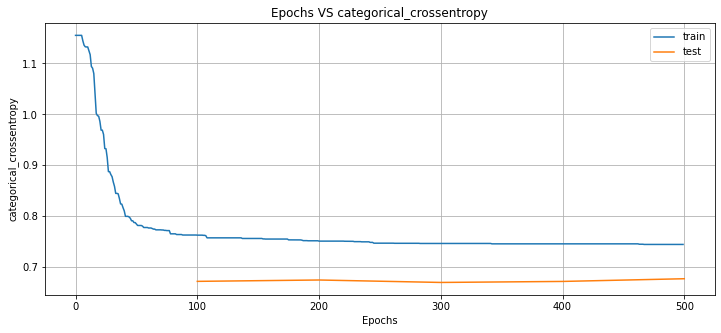

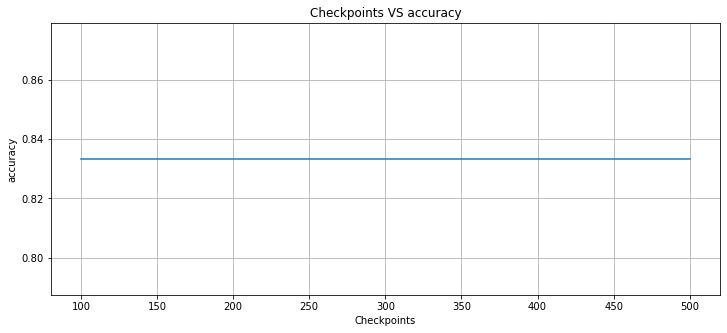

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8333333333333334, 'mean_square_error': 2.8578837331674456, 'categorical_crossentropy': 0.672111087375217, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 23, 'tn_hit': 7, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 100} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.8860325316545925, 'categorical_crossentropy': 0.6747787616871022, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 23, 'tn_hit': 7, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 200} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.7623988728124464, 'categorical_crossentropy': 0.669981426662869, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 23, 'tn_hit': 7, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit'

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[[ 0.08835523]
 [ 0.05005779]
 [ 0.01444759]
 [-0.00182552]
 [ 0.04966687]]
 bias: [-0.00548784]

Neuron 1: weights:
[[-0.17312238]
 [-0.09934001]
 [-0.36514255]
 [-0.17006905]
 [-0.2913359 ]]
 bias: [0.5401434]

Neuron 2: weights:
[[-0.17441982]
 [-0.05171634]
 [-0.12456728]
 [-0.11588535]
 [-0.17715663]]
 bias: [-0.00864103]

Neuron 3: weights:
[[0.17702752]
 [0.218718  ]
 [0.06521478]
 [0.25677794]
 [0.10313018]]
 bias: [-0.07260557]

$
Layer 2
Neuron 0: weights:
[[-0.06424912]
 [ 1.3973852 ]
 [ 1.529962  ]
 [-0.4723936 ]]
 bias: [0.00473825]

Neuron 1: weights:
[[-0.06840678]
 [-0.01267687]
 [ 0.0005334 ]
 [ 0.11053539]]
 bias: [0.07861186]

Neuron 2: weights:
[[-0.06078446]
 [-0.9636655 ]
 [-0.25897896]
 [ 0.64212096]]
 bias: [-0.02996659]

$

